<h1>Validator for br2_act_LC {ActCons, ActGen} 2013-2025<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Resources-used" data-toc-modified-id="Resources-used-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Resources used</a></span></li><li><span><a href="#Loading-and-preprocessing-data" data-toc-modified-id="Loading-and-preprocessing-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading and preprocessing data</a></span></li><li><span><a href="#Сore-Functions" data-toc-modified-id="Сore-Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Сore Functions</a></span></li><li><span><a href="#Model-validation" data-toc-modified-id="Model-validation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model validation</a></span></li><li><span><a href="#Model-metrics-calculation" data-toc-modified-id="Model-metrics-calculation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model metrics calculation</a></span></li></ul></div>

# Resources used

In [1]:
import os
import re
import locale
import requests
import warnings
import calendar
from bs4 import BeautifulSoup
from tqdm.notebook import trange

import notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from platform import python_version
import xgboost as xgb
import graphviz
from datetime import time
from datetime import datetime
from datetime import timedelta
import sklearn
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LearningCurveDisplay

# Глобальные гиперпараметры
period = 10
max_depth = 5
n_estimators = 200

print(f"python: v {python_version()}")
print(f"Jupyter Notebook: v {notebook.__version__}")
print(f"numpy: v {np.__version__}")
print(f"pandas: v {pd.__version__}")
print(f"seaborn: v {sns.__version__}")
print(f"graphviz: v {graphviz.__version__}")
print(f"matplotlib: v {matplotlib.__version__}")
print(f"sklearn: v {sklearn.__version__}")
print(f"XGBoost: v {xgb.__version__}")

python: v 3.10.7
Jupyter Notebook: v 6.4.12
numpy: v 1.25.2
pandas: v 2.2.3
seaborn: v 0.13.2
graphviz: v 0.20.1
matplotlib: v 3.6.2
sklearn: v 1.4.2
XGBoost: v 2.1.2


# Loading and preprocessing data

Loading and checking Data

In [2]:
df = pd.read_excel('DataBase.xlsx')

def is_check_DataBase(df):
    
    i, date, status = 0, df.iloc[0].Date, True
    
    while (date != df.iloc[-1].Date):
        if df.iloc[i].Date != date:
            status = False
            print("\033[1;31m{}".format(f'WARNING: no data on date {date}'))
        else:
            i += 1
        date += timedelta(hours=1)
    
    if df.isnull().any().any():
        status = False
        print('\033[1;31m{}'.format(f'WARNING: The database contains NULL:\n{df[df.isnull().any(axis=1)].Date}'))
        
    if status:
        print("\033[1;32m{}".format(f'The database is complete'))
        
    #return status
    
is_check_DataBase(df)

The database is complete


Creating a global variable with a DataBase indexed by date

In [3]:
df_general_date_index = df.set_index('Date')

Create an empty DataFrame (from 0:00 to 24:00) for the specified date

In [4]:
def get_empty_daily_df(date):
    return pd.DataFrame(pd.date_range(date, periods=25, freq='h'), columns=['Date'])
    
#get_empty_daily_df(datetime(2024,6,5))

Adding categorical features to the DataFrame

In [5]:
def add_date_scalar(df):
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] =  df.Date.dt.day
    df['Hour'] = df.Date.dt.hour
    df['Hour'] = df['Hour']
    df['Weekday'] = df.Date.dt.weekday
    return df

#add_date_scalar(test_df)

Downloading the weather archive for the specified date

In [6]:
def get_weather(date):
    # remove # when working offline
    #return get_empty_daily_df(date).merge(df_general_date_index.Temperature, how='left', on='Date').tail(24)
    
    months = ['', 'января', 'февраля', 'марта', 'апреля', 'мая', 'июня', 
              'июля', 'августа', 'сентября', 'октября', 'ноября', 'декабря']  # month names
            
    while True:  # repeat the request until a positive HTTP response is received from the server
        try:
            # download the content of the page https://kazan.nuipogoda.ru/ into a variable
            page = requests.get(url=f'https://kazan.nuipogoda.ru/{date.day}-{months[date.month]}#{date.year}', timeout=10)  # Добавили timeout
            page.raise_for_status()  # Check for HTTP errors
            break
        except requests.exceptions.RequestException as error:  # catch all requests errors
            print(f'{error} for {date}')
            
    # save the HTML code of the page into a variable
    soup = BeautifulSoup(page.text, 'html.parser')

    # filter tags with temperature
    trs = soup.find_all('tr', time=re.compile(r'[0-9]'))

    # get raw data
    day_weather_df = list()

    for tr in trs:
        day_weather_df.append((list(tr.attrs.values())[0], tr.find('span', class_='ht').text[:-1]))

    # create an interpretable dataframe
    day_weather_df = pd.DataFrame(day_weather_df, columns=['Date', 'Temperature']).astype('int64')
    day_weather_df.Date = pd.to_datetime(day_weather_df.Date, unit='ms')
    
    if (date.day == 31 and date.month == 12):  # transitioning to the next year
        day_weather_df = day_weather_df[((day_weather_df.Date.dt.year == date.year) &
                                        (day_weather_df.Date.dt.month == date.month)) | 
                                        (day_weather_df.Date == datetime.combine(date + timedelta(days=1), time(hour=0)))]
    else:
        day_weather_df = day_weather_df[day_weather_df.Date.dt.year == date.year]
    
    # interpolate missing temperature values (3rd-order polynomial) between 0, 3, 6, 9, 12, 15, 18, 21, and 24 hours
    day_weather_df = get_empty_daily_df(date).merge(day_weather_df, how='left', on='Date')
    day_weather_df.Temperature = day_weather_df.Temperature.interpolate(method='polynomial', order=3).round(1)    
    
    return day_weather_df.tail(24)  # return the weather dataframe from 1:00 to 24:00

#get_weather(datetime.now().date() - timedelta(days=1))

Get Balancing energy Market (BM) data on request from the DataBase

In [7]:
def get_br_feature(date):    
    return get_empty_daily_df(date).merge(df_general_date_index[['PredCons', 'ActCons', 'PredGen',  'ActGen']], 
                                          how='left', on='Date')

#get_br_feature(datetime(2024,11,9))

Replace missing *actual* (`Act`) values of BEM consumption and generation with *predicted* (`Pred`) values

In [8]:
def act_pred_reverse(df_br_feature):
    
    df_br_feature.ActCons = np.where(df_br_feature.ActCons == 0, df_br_feature.PredCons, df_br_feature.ActCons)
    df_br_feature.ActGen = np.where(df_br_feature.ActGen == 0, df_br_feature.PredGen, df_br_feature.ActGen)
    
    # remove redundant features (for further prediction)
    df_br_feature = df_br_feature.drop(columns=['PredCons', 'PredGen'])
    
    return df_br_feature

Preprocessing data

In [9]:
def get_type_day(df):
    
    # list of all weekends and holidays in Tatarstan from 2013 to 2024
    holidays = [
                datetime(2013, 1, 1).date(), datetime(2013, 1, 2).date(), datetime(2013, 1, 3).date(), datetime(2013, 1, 4).date(), datetime(2013, 1, 5).date(), datetime(2013, 1, 6).date(), datetime(2013, 1, 7).date(), datetime(2013, 1, 8).date(), datetime(2013, 2, 23).date(), datetime(2013, 3, 8).date(), datetime(2013, 5, 1).date(), datetime(2013, 5, 9).date(), datetime(2013, 6, 12).date(), datetime(2013, 8, 8).date(), datetime(2013, 8, 30).date(), datetime(2013, 10, 15).date(), datetime(2013, 11, 4).date(), datetime(2013, 11, 6).date(),
                datetime(2014, 1, 1).date(), datetime(2014, 1, 2).date(), datetime(2014, 1, 3).date(), datetime(2014, 1, 4).date(), datetime(2014, 1, 5).date(), datetime(2014, 1, 6).date(), datetime(2014, 1, 7).date(), datetime(2014, 1, 8).date(), datetime(2014, 2, 23).date(), datetime(2014, 3, 8).date(), datetime(2014, 5, 1).date(), datetime(2014, 5, 9).date(), datetime(2014, 6, 12).date(), datetime(2014, 7, 28).date(), datetime(2014, 8, 30).date(), datetime(2014, 10, 4).date(), datetime(2014, 11, 4).date(), datetime(2014, 11, 6).date(),
                datetime(2015, 1, 1).date(), datetime(2015, 1, 2).date(), datetime(2015, 1, 3).date(), datetime(2015, 1, 4).date(), datetime(2015, 1, 5).date(), datetime(2015, 1, 6).date(), datetime(2015, 1, 7).date(), datetime(2015, 1, 8).date(), datetime(2015, 2, 23).date(), datetime(2015, 3, 8).date(), datetime(2015, 5, 1).date(), datetime(2015, 5, 9).date(), datetime(2015, 6, 12).date(), datetime(2015, 7, 17).date(), datetime(2015, 8, 30).date(), datetime(2015, 9, 24).date(), datetime(2015, 11, 4).date(), datetime(2015, 11, 6).date(),
                datetime(2016, 1, 1).date(), datetime(2016, 1, 2).date(), datetime(2016, 1, 3).date(), datetime(2016, 1, 4).date(), datetime(2016, 1, 5).date(), datetime(2016, 1, 6).date(), datetime(2016, 1, 7).date(), datetime(2016, 1, 8).date(), datetime(2016, 2, 23).date(), datetime(2016, 3, 8).date(), datetime(2016, 5, 1).date(), datetime(2016, 5, 9).date(), datetime(2016, 6, 12).date(), datetime(2016, 7, 5).date(), datetime(2016, 8, 30).date(), datetime(2016, 9, 12).date(), datetime(2016, 11, 4).date(), datetime(2016, 11, 6).date(),
                datetime(2017, 1, 1).date(), datetime(2017, 1, 2).date(), datetime(2017, 1, 3).date(), datetime(2017, 1, 4).date(), datetime(2017, 1, 5).date(), datetime(2017, 1, 6).date(), datetime(2017, 1, 7).date(), datetime(2017, 1, 8).date(), datetime(2017, 2, 23).date(), datetime(2017, 3, 8).date(), datetime(2017, 5, 1).date(), datetime(2017, 5, 9).date(), datetime(2017, 6, 12).date(), datetime(2017, 6, 25).date(), datetime(2017, 8, 30).date(), datetime(2017, 9, 1).date(), datetime(2017, 11, 4).date(), datetime(2017, 11, 6).date(),
                datetime(2018, 1, 1).date(), datetime(2018, 1, 2).date(), datetime(2018, 1, 3).date(), datetime(2018, 1, 4).date(), datetime(2018, 1, 5).date(), datetime(2018, 1, 6).date(), datetime(2018, 1, 7).date(), datetime(2018, 1, 8).date(), datetime(2018, 2, 23).date(), datetime(2018, 3, 8).date(), datetime(2018, 5, 1).date(), datetime(2018, 5, 9).date(), datetime(2018, 6, 12).date(), datetime(2018, 6, 15).date(), datetime(2018, 8, 21).date(), datetime(2018, 8, 30).date(), datetime(2018, 11, 4).date(), datetime(2018, 11, 6).date(),
                datetime(2019, 1, 1).date(), datetime(2019, 1, 2).date(), datetime(2019, 1, 3).date(), datetime(2019, 1, 4).date(), datetime(2019, 1, 5).date(), datetime(2019, 1, 6).date(), datetime(2019, 1, 7).date(), datetime(2019, 1, 8).date(), datetime(2019, 2, 23).date(), datetime(2019, 3, 8).date(), datetime(2019, 5, 1).date(), datetime(2019, 5, 9).date(), datetime(2019, 6, 4).date(), datetime(2019, 6, 12).date(), datetime(2019, 8, 11).date(), datetime(2019, 8, 30).date(), datetime(2019, 11, 4).date(), datetime(2019, 11, 6).date(),
                datetime(2020, 1, 1).date(), datetime(2020, 1, 2).date(), datetime(2020, 1, 3).date(), datetime(2020, 1, 4).date(), datetime(2020, 1, 5).date(), datetime(2020, 1, 6).date(), datetime(2020, 1, 7).date(), datetime(2020, 1, 8).date(), datetime(2020, 2, 23).date(), datetime(2020, 3, 8).date(), datetime(2020, 5, 1).date(), datetime(2020, 5, 9).date(), datetime(2020, 5, 24).date(), datetime(2020, 6, 12).date(), datetime(2020, 7, 31).date(), datetime(2020, 8, 30).date(), datetime(2020, 11, 4).date(), datetime(2020, 11, 6).date(),
                datetime(2021, 1, 1).date(), datetime(2021, 1, 2).date(), datetime(2021, 1, 3).date(), datetime(2021, 1, 4).date(), datetime(2021, 1, 5).date(), datetime(2021, 1, 6).date(), datetime(2021, 1, 7).date(), datetime(2021, 1, 8).date(), datetime(2021, 2, 23).date(), datetime(2021, 3, 8).date(), datetime(2021, 5, 1).date(), datetime(2021, 5, 9).date(), datetime(2021, 5, 13).date(), datetime(2021, 6, 12).date(), datetime(2021, 7, 20).date(), datetime(2021, 8, 30).date(), datetime(2021, 11, 4).date(), datetime(2021, 11, 4).date(),
                datetime(2022, 1, 1).date(), datetime(2022, 1, 2).date(), datetime(2022, 1, 3).date(), datetime(2022, 1, 4).date(), datetime(2022, 1, 5).date(), datetime(2022, 1, 6).date(), datetime(2022, 1, 7).date(), datetime(2022, 1, 8).date(), datetime(2022, 2, 23).date(), datetime(2022, 3, 8).date(), datetime(2022, 5, 1).date(), datetime(2022, 5, 2).date(), datetime(2022, 5, 9).date(), datetime(2022, 6, 12).date(), datetime(2022, 7, 9).date(), datetime(2022, 8, 30).date(), datetime(2022, 11, 4).date(), datetime(2022, 11, 6).date(),
                datetime(2023, 1, 1).date(), datetime(2023, 1, 2).date(), datetime(2023, 1, 3).date(), datetime(2023, 1, 4).date(), datetime(2023, 1, 5).date(), datetime(2023, 1, 6).date(), datetime(2023, 1, 7).date(), datetime(2023, 1, 8).date(), datetime(2023, 2, 23).date(), datetime(2023, 3, 8).date(), datetime(2023, 4, 21).date(), datetime(2023, 5, 1).date(), datetime(2023, 5, 9).date(), datetime(2023, 6, 12).date(), datetime(2023, 6, 28).date(), datetime(2023, 8, 30).date(), datetime(2023, 11, 4).date(), datetime(2023, 11, 6).date(),
                datetime(2024, 1, 1).date(), datetime(2024, 1, 2).date(), datetime(2024, 1, 3).date(), datetime(2024, 1, 4).date(), datetime(2024, 1, 5).date(), datetime(2024, 1, 6).date(), datetime(2024, 1, 7).date(), datetime(2024, 1, 8).date(), datetime(2024, 2, 23).date(), datetime(2024, 3, 8).date(), datetime(2024, 4, 10).date(), datetime(2024, 5, 1).date(), datetime(2024, 5, 9).date(), datetime(2024, 6, 12).date(), datetime(2024, 6, 16).date(), datetime(2024, 8, 30).date(), datetime(2024, 11, 4).date(), datetime(2024, 11, 6).date(),
                datetime(2025, 1, 1).date(), datetime(2025, 1, 2).date(), datetime(2025, 1, 3).date(), datetime(2025, 1, 4).date(), datetime(2025, 1, 5).date(), datetime(2025, 1, 6).date(), datetime(2025, 1, 7).date(), datetime(2025, 1, 8).date(), datetime(2025, 2, 23).date(), datetime(2025, 3, 8).date(), datetime(2025, 3, 30).date(), datetime(2025, 5, 1).date(), datetime(2025, 5, 9).date(), datetime(2025, 6, 6).date(), datetime(2025, 6, 12).date(), datetime(2025, 8, 30).date(), datetime(2025, 11, 4).date(), datetime(2025, 11, 6).date(),              
               ]
    
    weekend = [
               datetime(2013, 5, 2).date(), datetime(2013, 5, 3).date(), datetime(2013, 5, 10).date(),
               datetime(2014, 3, 10).date(), datetime(2014, 5, 2).date(), datetime(2014, 6, 13).date(), datetime(2014, 9, 1).date(), datetime(2014, 10, 6).date(), datetime(2014, 11, 3).date(), 
               datetime(2015, 1, 9).date(), datetime(2015, 3, 9).date(), datetime(2015, 5, 4).date(), datetime(2015, 5, 11).date(), datetime(2015, 8, 31).date(),
               datetime(2016, 2, 22).date(), datetime(2016, 3, 7).date(), datetime(2016, 5, 2).date(), datetime(2016, 5, 3).date(), datetime(2016, 6, 13).date(), datetime(2016, 11, 7).date(),
               datetime(2017, 2, 24).date(), datetime(2017, 5, 8).date(),
               datetime(2018, 3, 9).date(), datetime(2018, 4, 30).date(), datetime(2018, 5, 2).date(), datetime(2018, 6, 11).date(), datetime(2018, 11, 5).date(), datetime(2018, 12, 31).date(),
               datetime(2019, 5, 2).date(), datetime(2019, 5, 3).date(), datetime(2019, 5, 10).date(),
               datetime(2020, 2, 24).date(), datetime(2020, 3, 9).date(), datetime(2020, 5, 4).date(), datetime(2020, 5, 5).date(), datetime(2020, 5, 11).date(),
               datetime(2021, 2, 22).date(), datetime(2021, 5, 3).date(), datetime(2021, 5, 10).date(), datetime(2021, 6, 14).date(), datetime(2021, 11, 5).date(), datetime(2021, 12, 31).date(),
               datetime(2022, 3, 7).date(), datetime(2022, 5, 3).date(), datetime(2022, 5, 10).date(), datetime(2022, 6, 13).date(),
               datetime(2023, 2, 24).date(), datetime(2023, 5, 8).date(),
               datetime(2024, 4, 29).date(), datetime(2024, 4, 30).date(), datetime(2024, 5, 10).date(), datetime(2024, 12, 30).date(), datetime(2024, 12, 31).date(),
               datetime(2025, 5, 2).date(), datetime(2025, 5, 8).date(), datetime(2025, 6, 13).date(), datetime(2025, 11, 3).date(), datetime(2025, 12, 31).date() 
              ]
    
    pre_holidays = [
                    datetime(2013, 2, 22).date(), datetime(2013, 3, 7).date(), datetime(2013, 4, 30).date(), datetime(2013, 5, 8).date(), datetime(2013, 6, 11).date(), datetime(2013, 8, 7).date(), datetime(2013, 8, 29).date(), datetime(2013, 10, 14).date(), datetime(2013, 11, 5).date(), datetime(2013, 12, 31).date(),
                    datetime(2014, 2, 24).date(), datetime(2014, 3, 7).date(), datetime(2014, 4, 30).date(), datetime(2014, 5, 8).date(), datetime(2014, 6, 11).date(), datetime(2014, 8, 29).date(), datetime(2014, 10, 3).date(), datetime(2014, 11, 5).date(), datetime(2014, 12, 31).date(),
                    datetime(2015, 4, 30).date(), datetime(2015, 5, 8).date(), datetime(2015, 6, 11).date(), datetime(2015, 7, 16).date(), datetime(2015, 9, 23).date(), datetime(2015, 11, 3).date(), datetime(2015, 11, 5).date(), datetime(2015, 12, 31).date(),
                    datetime(2016, 2, 20).date(), datetime(2016, 7, 4).date(), datetime(2016, 8, 29).date(), datetime(2016, 11, 3).date(),
                    datetime(2017, 2, 22).date(), datetime(2017, 3, 7).date(), datetime(2017, 8, 29).date(), datetime(2017, 8, 31).date(), datetime(2017, 11, 3).date(),            
                    datetime(2018, 2, 22).date(), datetime(2018, 3, 7).date(), datetime(2018, 4, 28).date(), datetime(2018, 5, 8).date(), datetime(2018, 6, 9).date(), datetime(2018, 6, 14).date(), datetime(2018, 7, 20).date(), datetime(2018, 7, 29).date(), datetime(2018, 12, 29).date(),
                    datetime(2019, 2, 22).date(), datetime(2019, 3, 7).date(), datetime(2019, 4, 30).date(), datetime(2019, 5, 8).date(), datetime(2019, 6, 3).date(), datetime(2019, 6, 11).date(), datetime(2019, 8, 29).date(), datetime(2019, 11, 5).date(), datetime(2019, 12, 31).date(),
                    datetime(2020, 4, 30).date(), datetime(2020, 5, 8).date(), datetime(2020, 6, 11).date(), datetime(2020, 7, 30).date(), datetime(2020, 11, 3).date(), datetime(2020, 11, 5).date(), datetime(2020, 12, 31).date(),
                    datetime(2021, 2, 20).date(), datetime(2021, 4, 30).date(), datetime(2021, 5, 12).date(), datetime(2021, 6, 11).date(), datetime(2021, 7, 19).date(), datetime(2021, 11, 3).date(),
                    datetime(2022, 2, 22).date(), datetime(2022, 3, 5).date(), datetime(2022, 7, 8).date(), datetime(2022, 8, 29).date(), datetime(2022, 11, 3).date(),
                    datetime(2023, 2, 22).date(), datetime(2023, 3, 7).date(), datetime(2023, 4, 20).date(),  datetime(2023, 6, 27).date(), datetime(2023, 8, 29).date(), datetime(2023, 11, 3).date(),
                    datetime(2024, 2, 22).date(), datetime(2024, 3, 7).date(), datetime(2024, 4, 9).date(), datetime(2024, 5, 8).date(), datetime(2024, 6, 11).date(), datetime(2024, 8, 29).date(), datetime(2024, 11, 2).date(), datetime(2024, 11, 5).date(),
                    datetime(2025, 3, 7).date(), datetime(2025, 4, 30).date(), datetime(2025, 6, 5).date(), datetime(2025, 6, 11).date(), datetime(2025, 8, 29).date(), datetime(2025, 11, 1).date(), datetime(2025, 11, 5).date()
                   ]
    
    workdays = [datetime(2024, 4, 27).date(), datetime(2024, 12, 28).date()]
    
    if df.Date.date() in workdays:
        TypeDay = 0
    elif df.Date.date() in pre_holidays:
        TypeDay = 1   
    elif df.Date.date() in weekend:
        TypeDay = 3 
    elif df.Date.date() in holidays:
        TypeDay = 2 
    elif (df.Weekday == 5) | (df.Weekday == 6):
        TypeDay = 3
    else:
        TypeDay = 0
    return TypeDay

In [10]:
def prepareData(df, lag_start=1, lag_end=7):        
        
    # coding of weekends and holidays
    df['TypeDay'] = df.apply(get_type_day, axis=1)
    
    df = df.set_index('Date')
    
    # add daily lags of the original series (default is 1 full week)
    for i in range(lag_start, lag_end + 1):    
        df[f"lag-{i}"] = df.Volume.shift(freq=f"{i}D")  # we make a shift to the i-th day by index 

    # remove the first 24*lag_end records with missing data (168 records for a 7-day lag)
    df = df.dropna(subset=['lag-1', 'lag-2', 'lag-3', 'lag-4', 'lag-5', 'lag-6', 'lag-7'])
    df.reset_index(inplace=True)
    
    return df

Adding/removing/changing features

In [11]:
# form the general set
df_general = df.copy()

# add new features
df_general = prepareData(df_general)

# remove columns with forecasted values of BEM generation and consumption
df_general = df_general.drop(columns=['PredCons', 'PredGen', 'Price'])

df_general.iloc[:, 1:]

,Year,Month,Day,Hour,Weekday,Volume,Temperature,ActCons,ActGen,TypeDay,lag-1,lag-2,lag-3,lag-4,lag-5,lag-6,lag-7
0,2013,1,8,1,1,2017.102000,-6.1,2875,2568,2,1983.630000,1984.007000,2000.216000,1972.473000,2008.811,2027.193,2033.264
1,2013,1,8,2,1,1964.942000,-6.1,2781,2580,2,1932.213000,1934.204000,1950.523000,1920.304000,1953.228,1970.887,1987.714
2,2013,1,8,3,1,1938.221000,-6.0,2737,2581,2,1904.510000,1907.831000,1920.106000,1889.606000,1915.720,1938.669,1955.861
3,2013,1,8,4,1,1929.957000,-6.0,2761,2576,2,1895.918000,1897.508000,1915.331000,1882.192000,1904.349,1931.414,1944.520
4,2013,1,8,5,1,1950.473000,-6.0,2763,2575,2,1921.034000,1904.977000,1922.729000,1902.160000,1905.641,1939.466,1964.332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108763,2025,6,5,20,3,2561.903797,18.6,4127,3868,1,2539.725131,2563.724502,2613.908383,2605.637614,2578.146,2641.198,2653.362
108764,2025,6,5,21,3,2598.473502,17.0,4164,3805,1,2584.616371,2607.633057,2622.134405,2666.234702,2627.777,2665.976,2690.704
108765,2025,6,5,22,3,2611.434013,15.4,4065,3666,1,2583.034630,2633.566958,2591.983765,2606.081067,2629.026,2692.103,2698.876
108766,2025,6,5,23,3,2468.343446,14.1,3917,3476,1,2418.571382,2465.536150,2442.039994,2448.642317,2496.627,2539.111,2537.725


# Сore Functions

Function for model training and forecasting energy consumption volumes

In [12]:
def predict_volume(df_general, df_predict, datetime):

    # form the optimal training sample
    df_train = df_general[df_general.Date > datetime - timedelta(days=365*period+1, hours=1)]

    # model training
    model = xgb.XGBRegressor(device = 'cpu',
                             n_estimators = n_estimators,
                             max_depth = max_depth)

    model.fit(df_train.drop(columns=['Date', 'Volume']), df_train.Volume)

    # predict consumption volumes for the next day
    df_predict.Volume = model.predict(df_predict.drop(columns=['Date', 'Volume']))
   
    return df_predict

Function for generating a dataframe with predicted energy consumption volumes for the specified planning horizon

In [13]:
# define the planning horizon (by default – one day ahead from the current date)
def get_df_predicted(df_general,
                     date_start=datetime.now().date(), 
                     date_end=datetime.now().date() + timedelta(days=1)):
    
    # generate an empty dataframe for the final result
    df_predicted = pd.DataFrame()
    
    for date in range((date_end - date_start).days + 1):
    
        # generate an empty daily dataframe with weather and calendar features
        df_predicted_daily = add_date_scalar(get_weather(date_start + timedelta(days=date)))

        # split the training logic (current day with BEM data, subsequent days without BEM data)
        if date == 0:
            
            # download data (forecast and some actual) from the BEM for the current day
            df_predicted_daily = df_predicted_daily.merge(get_br_feature(date_start), on='Date')
            
            # reset all actual from 8:00 in df_predicted_daily (to simulate real conditions)
            df_predicted_daily.loc[df_predicted_daily.Date >= datetime.combine(date_start, time(hour=8)), 
                                   ['ActCons', 'ActGen']] = 0
            
            # fill missing ActCons and ActGen with data from PredCons and PredGen columns
            df_predicted_daily = act_pred_reverse(df_predicted_daily)
            
        elif date == 1:
            df_general = df_general.drop(columns=['ActCons', 'ActGen'])
        
        # add last 168 (24 · 7) rows from df_general to generate time lag
        df_predicted_daily = pd.concat([df_general.tail(168), df_predicted_daily])

        # generate a time lag (1 full week)
        df_predicted_daily = prepareData(df_predicted_daily)
        
        # obtain predicted values for the current day
        df_predicted_daily = predict_volume(df_general, 
                                            df_predicted_daily, 
                                            datetime.combine(date_start + timedelta(days=date), time(hour=1)))

        # add the obtained forecast values to the final forecast dataframe
        df_predicted = pd.concat([df_predicted, df_predicted_daily])

        # expand the general population with the current day (+24 rows) for planning the next day
        df_general = pd.concat([df_general, df_predicted_daily])

    df_predicted.rename(columns = {'Volume':'Predicted'}, inplace = True)
    
    return df_predicted[['Date', 'Predicted']].tail(24)

# Model validation

Determine the size of the validation set

In [14]:
# fragment of 2025
df_validate = df_general[(df_general.Date > datetime(2025, 1, 1, 0)) & 
                         (df_general.Date < datetime(2025, 6, 1, 1))]


df_validate.reset_index(drop=True, inplace=True)
df_validate.iloc[:, :-7]

,Date,Year,Month,Day,Hour,Weekday,Volume,Temperature,ActCons,ActGen,TypeDay
0,2025-01-01 01:00:00,2025,1,1,1,2,2524.247,-1.6,3922,3237,2
1,2025-01-01 02:00:00,2025,1,1,2,2,2476.771,-2.4,3868,3240,2
2,2025-01-01 03:00:00,2025,1,1,3,2,2411.522,-3.0,3801,3215,2
3,2025-01-01 04:00:00,2025,1,1,4,2,2369.143,-3.1,3729,3211,2
4,2025-01-01 05:00:00,2025,1,1,5,2,2347.515,-3.0,3713,3214,2
...,...,...,...,...,...,...,...,...,...,...,...
3619,2025-05-31 20:00:00,2025,5,31,20,5,2578.146,25.2,4030,3032,3
3620,2025-05-31 21:00:00,2025,5,31,21,5,2627.777,24.0,4090,2920,3
3621,2025-05-31 22:00:00,2025,5,31,22,5,2629.026,23.0,4061,2868,3
3622,2025-05-31 23:00:00,2025,5,31,23,5,2496.627,22.0,3858,2488,3


perform model validation

In [15]:
%%time

# final validation dataframe with predicted values
df_validate_result = pd.DataFrame()

# daily validation for the selected interval
for i in trange(int((df_validate.shape[0]) / 24), desc=f"days progress"):
    
    # form the prediction date
    idate = df_validate.iloc[0].Date + timedelta(days=i)
    
    # limit the size of the general set (up to -2 days before the forecast date)
    df_general_cut = df_general[df_general.Date < idate - timedelta(days=1)]
    
    # perform a prediction for the specified date (considering -1 day)
    df_predicted = get_df_predicted(df_general_cut, 
                                    date_start=idate.date()-timedelta(days=1), 
                                    date_end=idate.date())
        
    # expand the validation frame with predicted values
    df_validate_result = pd.concat([df_validate_result, df_validate.merge(df_predicted, how='left', on='Date')])
    df_validate_result.dropna(inplace=True)

days progress:   0%|          | 0/151 [00:00<?, ?it/s]

CPU times: total: 27min 2s
Wall time: 5min 4s


Export the validation dataframe to an *.xlsx file

In [16]:
df_validate_result.to_excel(f'Predicted(br_2_act)Jan_May_2025_LC(10,5).xlsx', index=False)

# Model metrics calculation

In [2]:
df_validate_result = pd.read_excel(f'Predicted(br_2_act)Jan_May_2025_LC(10,5).xlsx')
df_RSV_vs_BR_rate = pd.read_excel('diff_RSV_rate.xlsx')

# add penalty tariffs of the BEM to the final table
df_validate_result = df_validate_result.merge(df_RSV_vs_BR_rate, how='left', on='Date')
df_validate_result = df_validate_result[['Date', 'Month', 'Volume', 'Predicted', 'A_gr_P', 'P_gr_A']]

# estimate the losses from operating on the BEM
df_validate_result['diff_cons'] = df_validate_result.Volume - df_validate_result.Predicted
df_validate_result['loss'] = np.where(df_validate_result.diff_cons > 0, 
                                      df_validate_result.diff_cons * df_validate_result.A_gr_P, 
                                      abs(df_validate_result.diff_cons) * df_validate_result.P_gr_A)

MAE: 38.487 [MW]
MAPE: 1.411%

MLFBM: 4615.36 RUR 
MedLFBM: 319.47 RUR 
CLFBM: [2025-01-01 ÷ 2025-06-01]: 16726061.83 RUR

January 2025	MAPE: 1.636%	Mean loss: 3922.16 RUR	Median loss: 213.89 RUR	Sum loss: 2914161.83 RUR
February 2025	MAPE: 1.242%	Mean loss: 2651.72 RUR	Median loss: 127.88 RUR	Sum loss: 1781953.9 RUR
March 2025	MAPE: 1.122%	Mean loss: 1502.06 RUR	Median loss: 142.97 RUR	Sum loss: 1117530.33 RUR
April 2025	MAPE: 1.490%	Mean loss: 3326.66 RUR	Median loss: 821.53 RUR	Sum loss: 2395196.02 RUR
May 2025	MAPE: 1.548%	Mean loss: 11447.88 RUR	Median loss: 726.85 RUR	Sum loss: 8517219.75 RUR


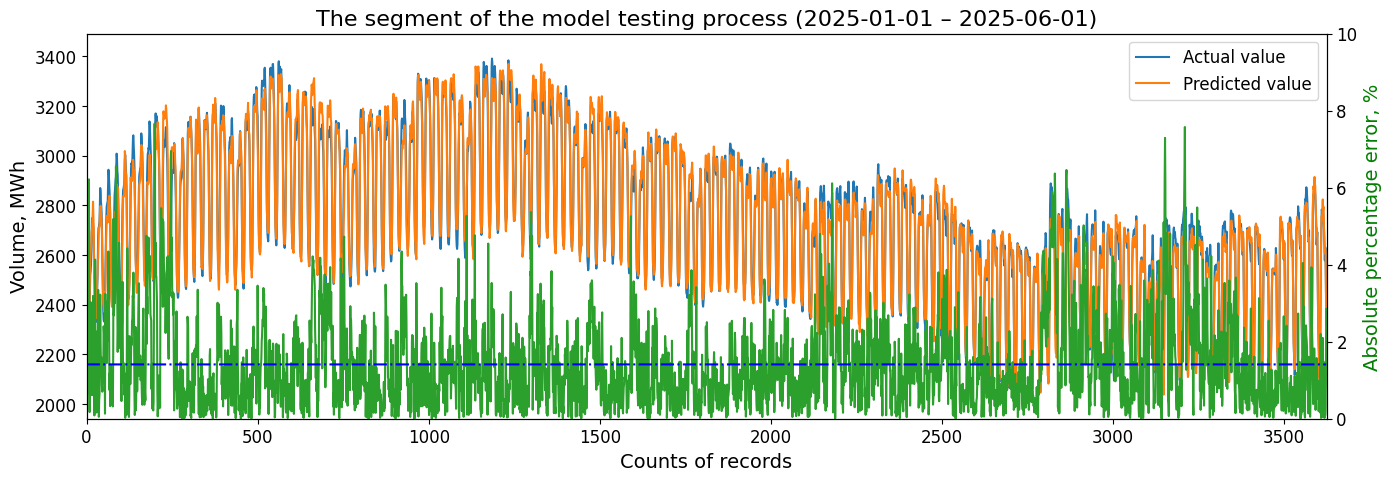

In [5]:
def diff_predict_vs_fact(df_validate_result):
    
    df_validate = df_validate_result.copy()
    
    # adding new columns (for calculating average error)
    df_validate.insert(df_validate.shape[1], 'MAPE', 
                       MAPE(df_validate.Predicted, df_validate.Volume)*100)

    df_validate['Error'] = abs((df_validate.Volume - df_validate.Predicted)*100 / df_validate.Volume)

    df_validate.reset_index(drop=True, inplace=True)

    fig, df_volume = plt.subplots(figsize=(16,5))
    df_error = df_volume.twinx()

    df_volume.plot(df_validate.Volume, label='Actual value')
    df_volume.plot(df_validate.Predicted, label='Predicted value')
    df_error.plot(df_validate.Error, label='Error, %', color='#2ca02c')
    df_error.plot(df_validate.MAPE, '-.b')

    plt.rcParams['font.size'] = '12'

    df_volume.legend(loc='upper right')
    df_volume.set_xlim(0, df_validate.shape[0])
    df_volume.set_ylim(df_validate.Volume.min() - 100, df_validate.Volume.max() + 100)
    df_volume.set_ylabel('Volume, MWh', fontsize = 14)
    df_volume.set_xlabel('Counts of records', fontsize = 14)

    df_error.set_ylim(0, 10)
    df_error.set_ylabel('Absolute percentage error, %', fontsize = 14, color='g')

    title = 'The segment of the model testing process'
    plt.title(f'{title} ({df_validate.iloc[0].Date.date()} – {df_validate.iloc[-1].Date.date()})', fontsize = 16)
    
    print(f'MAE: {MAE(df_validate.Predicted, df_validate.Volume):.3f} [MW]',
          f'MAPE: {MAPE(df_validate.Predicted, df_validate.Volume):.3%}', sep='\n')

    print(f'\nMLFBM: {round(df_validate.loss.mean(), 2)} RUR',          
          f'\nMedLFBM: {round(df_validate.loss.median(), 2)} RUR',
          f'\nCLFBM: [{df_validate.iloc[0].Date.date()} ÷ {df_validate.iloc[-1].Date.date()}]:', 
          f'{round(df_validate.loss.sum(), 2)} RUR', end='\n\n')
    
    df_validate.Month = df_validate.Date.apply(lambda x: f"{x.month_name()} {x.year}")
    list_months = list(df_validate.Month.unique())[:-1]

    for month in list_months:
    
        df_month = df_validate[df_validate.Month == month]
    
        print(f'{month}',
              f'MAPE: {MAPE(df_month.Predicted, df_month.Volume):.3%}',
              f'Mean loss: {round(df_month.loss.mean(), 2)} RUR',
              f'Median loss: {round(df_month.loss.median(), 2)} RUR',
              f'Sum loss: {round(df_month.loss.sum(), 2)} RUR', sep='\t')

diff_predict_vs_fact(df_validate_result)